In [1]:
from fastai.vision.all import *
from fastcore.foundation import L
import torch
import matplotlib.pyplot as plt

def visualize_average_masks(mask_folder, label_classes, save_path=None):
    """
    Generates and displays an image showing the average mask for each class in grayscale.
    
    Parameters:
        mask_folder (str): Path to the folder containing segmentation masks.
        label_classes (list): List of class labels.
        save_path (str, optional): Path to save the output visualization.
        
    Returns:
        None
    """
    num_classes = len(label_classes)

    # Assign grayscale intensities (background = 0, other classes = increasing shades of gray)
    gray_shades = torch.linspace(0.2, 1.0, steps=num_classes)  # Avoid pure black (0) for foreground classes

    # Load mask files
    mask_files = get_image_files(mask_folder)
    if not mask_files:
        print("No mask files found in the directory!")
        return
    
    mask_sums = {label: None for label in label_classes}
    mask_counts = {label: 0 for label in label_classes}

    # Process masks
    first_valid_mask = None  # Placeholder to get shape

    for mask_file in progress_bar(mask_files):
        mask = TensorImage(PILMask.create(mask_file))  # Load mask as tensor
        
        if first_valid_mask is None:
            first_valid_mask = mask  # Store first valid mask to determine image shape

        for class_idx, class_label in enumerate(label_classes):
            class_mask = (mask == class_idx).float()  # Binary mask for each class

            if mask_sums[class_label] is None:
                mask_sums[class_label] = torch.zeros_like(mask, dtype=torch.float32)

            mask_sums[class_label] += class_mask
            mask_counts[class_label] += 1

    if first_valid_mask is None:
        print("No valid masks were processed!")
        return

    # Create a figure to display grayscale class-wise average masks
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 4, 4))

    if num_classes == 1:
        axes = [axes]  # Ensure iterable when only one class exists

    for ax, (class_idx, class_label) in zip(axes, enumerate(label_classes)):
        if mask_counts[class_label] > 0:
            avg_mask = mask_sums[class_label] / mask_counts[class_label]  # Normalize
            gray_mask = avg_mask * gray_shades[class_idx]  # Apply grayscale intensity

            ax.imshow(gray_mask.cpu().numpy(), cmap="gray", vmin=0, vmax=1)
            ax.set_title(f"{class_label}")
            ax.axis("off")

    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()

# Example usage
# visualize_average_masks("dataset/labeled_data/masks", ["background", "anterior", "posterior"], save_path="average_masks.png")

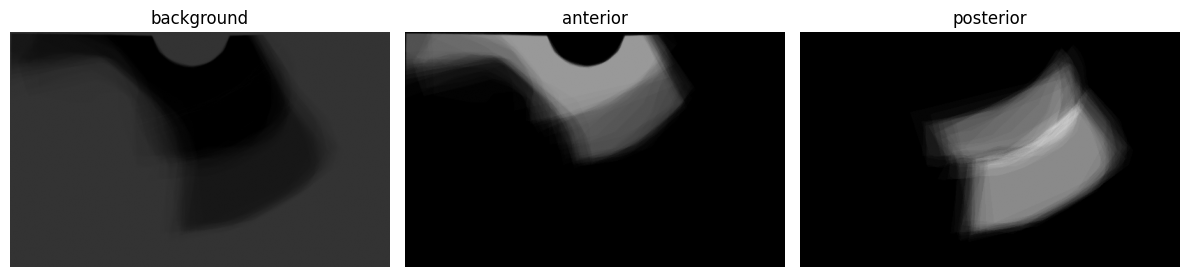

In [2]:
# Example usage
visualize_average_masks("dataset/labeled_data/labels", ["background", "anterior", "posterior"], save_path="labeled_average_masks.png")

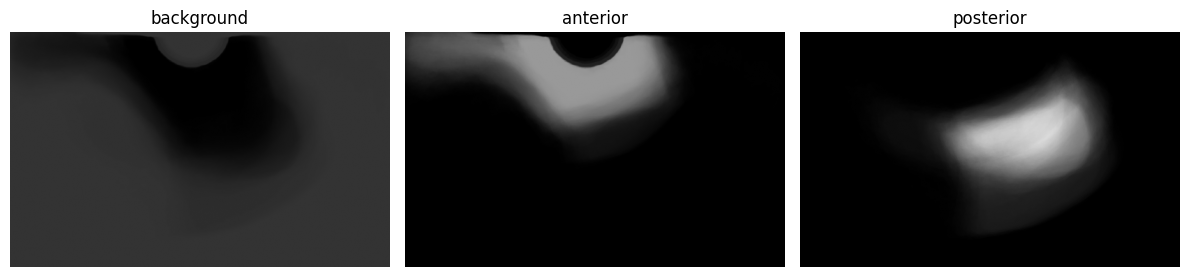

In [3]:
visualize_average_masks("dataset/unlabeled_data/labels", ["background", "anterior", "posterior"], save_path="unlabeled_average_masks.png")

In [18]:
import os
import numpy as np
import pandas as pd
import cv2
from tabulate import tabulate
from collections import defaultdict
from fastai.vision.all import get_image_files

def compute_pixel_counts(mask_folder, class_labels, save_path):
    """
    Computes the number of pixels per class in the dataset, calculates percentages,
    and displays a formatted table. Saves the table as a CSV file.
    
    Parameters:
    mask_folder (str): Path to the folder containing segmentation masks.
    save_path (str): Path to save the generated table as a CSV file.
    class_labels (dict): Dictionary mapping class index to class name.
    """
    pixel_counts = defaultdict(int)
    total_pixels = 0
    
    # Get mask image files
    mask_files = get_image_files(mask_folder)
    
    # Iterate through mask images
    for mask_path in mask_files:
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        
        if mask is None:
            print(f"Warning: Could not read {mask_path}")
            continue
        
        unique, counts = np.unique(mask, return_counts=True)
        for label, count in zip(unique, counts):
            pixel_counts[label] += count
            total_pixels += count
    
    # Compute percentages
    table_data = []
    for class_idx, class_name in class_labels.items():
        count = pixel_counts.get(class_idx, 0)
        percentage = (count / total_pixels) * 100 if total_pixels > 0 else 0
        table_data.append([class_name, count, f"{percentage:.2f}%"])
    
    # Convert to Pandas DataFrame
    df = pd.DataFrame(table_data, columns=["Class", "Pixel Count", "Percentage"])
    print(tabulate(df, headers='keys', tablefmt='grid'))
    
    # Save DataFrame as CSV
    df.to_csv(save_path, index=False)
    print(f"CSV file saved at {save_path}")


# Define the path to the folder containing segmentation masks
mask_folder = Path("dataset/labeled_data/labels/")

# Define the path to save the CSV file
save_path = "pixel_counts.csv"

# Define the class labels mapping (index -> class name)
class_labels = {
    0: "Background",
    1: "Anterior",
    2: "Posterior",
}

# Call the function
compute_pixel_counts(mask_folder, class_labels, save_path)

+----+------------+---------------+--------------+
|    | Class      |   Pixel Count | Percentage   |
+====+============+===============+==============+
|  0 | Background |       6925828 | 75.78%       |
+----+------------+---------------+--------------+
|  1 | Anterior   |       1288927 | 14.10%       |
+----+------------+---------------+--------------+
|  2 | Posterior  |        924445 | 10.12%       |
+----+------------+---------------+--------------+
CSV file saved at pixel_counts.csv


In [ ]:
dataset/labeled_data/labels/